Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Test CSV File

In [ ]:
from csv import writer as wcsv, reader as rcsv
csvfile = "/content/drive/My Drive/Project/demo.csv"
List = ["ID", "Type", "Plate Number"]
with open(csvfile, 'w') as csvfileobject:
          csvwriter = wcsv(csvfileobject)
          csvwriter.writerow(List)
          csvfileobject.close()

## Vehicle Classification and Plate Recognization

### Import necessary packages

In [ ]:
import sys
sys.path.insert(0,'/content/drive/My Drive/Project/')
from IPython import get_ipython
get_ipython().magic('reset -sf')
import cv2
import collections
import numpy as np
from google.colab.patches import cv2_imshow
from IPython.display import clear_output
import time
import pandas as pd
import heapq
import imutils
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import load_model

from tools import generate_detections as gdet
from deep_sort import preprocessing
from deep_sort import nn_matching
from deep_sort.detection import Detection
from deep_sort.tracker import Tracker

### Configure the Environment

In [ ]:
# Initialize Tracker
max_cosine_distance = 0.8
nn_budget = None
model_filename = '/content/drive/My Drive/Project/deep_sort/mars-small128.pb'
encoder = gdet.create_box_encoder(model_filename, batch_size=1)
metric = nn_matching.NearestNeighborDistanceMetric("cosine", max_cosine_distance, nn_budget)
tracker = Tracker(metric, n_init = 0)

# Initialize the videocapture object
cap = cv2.VideoCapture('/content/drive/My Drive/Project/test1.mp4')
outputVideoPath = "output.avi"
input_size = 320

# Detection confidence threshold
confThreshold =0.2
nmsThreshold= 0.2

font_color = (0, 0, 255)
font_size = 0.5
font_thickness = 2

# Store Coco Names in a list
csvfile = "/content/drive/My Drive/Project/demo.csv"
classesFile = "/content/drive/My Drive/Project/coco.names"
classNames = open(classesFile).read().strip().split('\n')
# print(classNames)
#print(len(classNames))

# class index for our required detection classes
required_class_index = [2, 3, 5, 7]

detected_classNames = []

## Model Files
modelConfiguration = '/content/drive/My Drive/Project/yolov3-320.cfg'
modelWeigheights = '/content/drive/My Drive/Project/yolov3-320.weights'

# configure the network model
net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeigheights)

# Configure the network backend

net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

# Define random colour for each class
# np.random.seed(42)
# colors = np.random.randint(0, 255, size=(len(classNames), 3), dtype='uint8')

def initializeVideoWriter(video_width, video_height, videoStream):
    # Getting the fps of the source video
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    # initialize our video writer
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    return cv2.VideoWriter(outputVideoPath, fourcc, fps,
        (video_width, video_height), True)

video_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
video_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
writer = initializeVideoWriter(video_width, video_height, cap)


# Function for finding the detected objects from the network output
def postProcess(outputs,img):
    cv2_imshow(img)
    height, width = img.shape[:2]
    boxes = []
    classIds = []
    confidence_scores = []
    confidence_s = []
    detection = []
    names = []
    for output in outputs:
        for det in output:
            scores = det[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if classId in required_class_index:
                if confidence > confThreshold:
                    # print(classId)
                    w,h = int(det[2]*width) , int(det[3]*height)
                    x,y = int((det[0]*width)-w/2) , int((det[1]*height)-h/2)
                    boxes.append([x,y,w,h])
                    classIds.append(classId)
                    confidence_scores.append(float(confidence))

    # Apply Non-Max Suppression
    indices = cv2.dnn.NMSBoxes(boxes, confidence_scores, confThreshold, nmsThreshold)

    # print("Car = ",indices)
    if len(indices)>0:
        for i in indices.flatten():
            x, y, w, h = boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3]
            # print(w,h)

            # color = [int(c) for c in colors[classIds[i]]]
            name = classNames[classIds[i]]
            names.append([name])
            detection.append([x, y, w, h])
            conf_s = round(confidence_scores[i],4)
            confidence_s.append([conf_s])
            # color = (255,0,255)
            # cv2.putText(img,f'{name} {int(confidence_scores[i]*100)}%',
            #         (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
            # cv2.rectangle(img, (x, y), (x + w, y + h), color, 1)
            # roi = img[int(y):int(y+h), int(x):int(x+w)]
            # from_static(roi)

            # boxes_ids = tracker.update(detections)
            # for box_id in boxes_ids:
            #     x11, y11, x22, y22, id = box_id
            #     id = int(id)
            #     # w, h = int(x2 - x1), int(y2 - y1)
            #     xc = int((x11 + x22) / 2)
            #     yc = int((y11 + y22) / 2)
            #     df = pd.read_csv(csvfile)
            #     if id in df['ID'].values:
            #       pass
            #     else:
            #         df.loc[len(df.index)] = [id, name, 1]
            #     df.to_csv(csvfile, index=False)

            #     cv2.putText(img,f'{id}',
            #         (xc, yc-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    features = encoder(img, detection)
    # DeepSORT -> Storing all the required info in a list.
    detections = [Detection(bbox, "{}".format(*score), cname, feature) for bbox, score, cname, feature in zip(detection, confidence_s, names, features)]

    # print(detections)
    #initialize color map
    cmap = plt.get_cmap('tab20b')
    colors = [cmap(i)[:3] for i in np.linspace(0, 1, 20)]

    # Call the tracker
    tracker.predict()
    tracker.update(detections)
    # print(len(tracker.tracks))
    for track in tracker.tracks:
        # if not track.is_confirmed() or track.time_since_update > 1:
        #     continue
        bbox = track.to_tlbr()
        class_name = track.get_class()[0]
        color = colors[int(track.track_id) % len(colors)]
        color = [i * 255 for i in color]
        # cv2.rectangle(img, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color, 1)
        # cv2.rectangle(img, (int(bbox[0]), int(bbox[1]-30)), (int(bbox[0])+(len(class_name)+len(str(track.track_id)))*40, int(bbox[1])), color, -1)
        # cv2.putText(img, f'{class_name} {track.track_id}',(int(bbox[0]), int(bbox[1]-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255),1)
        # print(f'{class_name} {track.track_id}')
        w = abs(bbox[2] - bbox[0])
        h = abs(bbox[3] - bbox[1])
        # cv2_imshow(img)
        if w>200 and h>200:
            vehicleframe = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
            # print(int(bbox[1])-50 , int(bbox[3])+50 , int(bbox[0])-50 , int(bbox[2])+50)
            flag = False
            if (int(bbox[1])-50 > 0 and int(bbox[3])+50 > 0 and int(bbox[0])-50 > 0 and int(bbox[2])+50 > 0):
                vehicleframe1 = img[int(bbox[1])-50:int(bbox[3])+50, int(bbox[0])-50:int(bbox[2])+50]
                flag = True
            else :
                vehicleframe1 = vehicleframe
            cv2.imwrite("vehicleframe.jpg", vehicleframe)
            cv2.imwrite("extvehicleframe.jpg", vehicleframe1)
            print(class_name)
            cv2_imshow(vehicleframe)
            plate_number = "Unable To Recognized"
            if class_name == "motorbike":
                print("bike")
                plate_number_img, nvf = bikelicenceplate(vehicleframe, vehicleframe1, flag)
                print("[INFO] Extract NumberPlate using Method 1...")
                if plate_number_img is not None:
                    cv2_imshow(plate_number_img)
                    if len(segment_characters(plate_number_img)) > 0:
                        plate_number = show_results2(plate_number_img)
                else:
                    print("[INFO] Extract NumberPlate using Method 2...")
                    if nvf == plate_number_img:
                        plate_number_img = extractNumberPlate(vehicleframe)
                    else:
                        plate_number_img = extractNumberPlate(nvf)
                    if plate_number_img is not None:
                        if len(segment_characters(plate_number_img)) > 0:
                            plate_number = show_results2(plate_number_img)
                    else:
                        print("[INFO] Extract NumberPlate using Method 3...")
                        if nvf == plate_number_img:
                            plate_number_img = extractNumberPlate2(vehicleframe)
                        else:
                            plate_number_img = extractNumberPlate2(nvf)
                        if plate_number_img is not None:
                            if len(segment_characters(plate_number_img)) > 0:
                                plate_number = show_results2(plate_number_img)
            else:
                plate_number_img, nvf = licenceplate(vehicleframe, vehicleframe1, flag)
                print("[INFO] Extract NumberPlate using Method 1...")
                if plate_number_img is not None:
                    cv2_imshow(plate_number_img)
                    if len(segment_characters(plate_number_img)) > 0:
                        plate_number = show_results2(plate_number_img)
                else:
                    print("[INFO] Extract NumberPlate using Method 2...")
                    if nvf == plate_number_img:
                        plate_number_img = extractNumberPlate(vehicleframe)
                    else:
                        plate_number_img = extractNumberPlate(nvf)
                    if plate_number_img is not None:
                        if len(segment_characters(plate_number_img)) > 0:
                            plate_number = show_results2(plate_number_img)
                    else:
                        print("[INFO] Extract NumberPlate using Method 3...")
                        if nvf == plate_number_img:
                            plate_number_img = extractNumberPlate2(vehicleframe)
                        else:
                            plate_number_img = extractNumberPlate2(nvf)
                        if plate_number_img is not None:
                            if len(segment_characters(plate_number_img)) > 0:
                                plate_number = show_results2(plate_number_img)

            print(plate_number)

            df = pd.read_csv(csvfile)
            id = track.track_id
            if id in df['ID'].values:
                if plate_number == "Unable To Recognized":
                    continue
                new_plate = plate_number
                old_plate = df.loc[df['ID'] == id, 'Plate Number'].values[0]
                df.loc[df['ID'] == id, 'Plate Number'] = f"{old_plate}, {new_plate}"
            else:
                new_entry = [id, class_name, plate_number]
                df.loc[len(df.index)] = new_entry

            df.to_csv(csvfile, index=False)


### Defining Functions

*   Licence Plate Localization
*  Character Segmentation & Coutours Detection

In [ ]:
def licenceplate(img, img2, flag):
    input_size = 320

    font_color = (0, 0, 255)
    font_size = 0.5
    font_thickness = 2
    # Store Coco Names in a list
    classesFiles = "/content/drive/My Drive/Project/classes.names"
    classNames = open(classesFiles).read().strip().split('\n')
    # print(classNames)
    # print(len(classNames))

    ## Model Files
    modelConfig = '/content/drive/My Drive/Project/darknet-yolov3.cfg'
    modelW = '/content/drive/My Drive/Project/lapi.weights'

    # configure the network model
    net = cv2.dnn.readNetFromDarknet(modelConfig, modelW)

    # Configure the network backend

    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

    if img is None:
        print("Image Error")
        return
    blob = cv2.dnn.blobFromImage(img, 1 / 255, (input_size, input_size), [0, 0, 0], 1, crop=False)

    # Set the input of the network
    net.setInput(blob)
    layersNames = net.getLayerNames()
    outputNames = [(layersNames[i - 1]) for i in net.getUnconnectedOutLayers()]
    # Feed data to the network
    outputs = net.forward(outputNames)

    # Find the objects from the network output
    # class index for our required detection classes
    required_class_ind = [0]
    # Detection confidence threshold
    confThreshold = 0.2
    nmsThreshold= 0.2
    scoreThreshold = 0.2
    # Define random colour for each class
    np.random.seed(42)
    colors = np.random.randint(0, 255, size=(len(classNames), 3), dtype='uint8')
    height, width = img.shape[:2]
    boxes = []
    classIds = []
    confidence_scores = []
    detection = []
    for output in outputs:
        for det in output:
            scores = det[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if classId in required_class_ind:
                if confidence > confThreshold:
                    w,h = int(det[2]*width) , int(det[3]*height)
                    x,y = int((det[0]*width)-w/2) , int((det[1]*height)-h/2)
                    boxes.append([x,y,w,h])
                    classIds.append(classId)
                    confidence_scores.append(float(confidence))

    # Apply Non-Max Suppression
    indices = cv2.dnn.NMSBoxes(boxes, confidence_scores, scoreThreshold, nmsThreshold)
    # print("LP =",indices)
    if len(indices) > 0:
        for i in indices.flatten():
            x, y, w, h = boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3]
            # print(x,y,w,h)

            color = [int(c) for c in colors[classIds[i]]]
            name = classNames[classIds[i]]

            # Draw classname and confidence score
            # cv2.putText(img,f'{name.upper()} {int(confidence_scores[i]*100)}%',
            #           (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

            # Draw bounding rectangle
            # cv2.rectangle(img, (x, y), (x + w, y + h), color, 1)
            # detection.append([x, y, w, h, required_class_ind.index(classIds[i])])
            # print(detection)
            if w>120 and h>20:
                roi = img[y:y+h, x:x+w]
                cv2.imwrite("lpoutput.jpg", roi)
                if flag:
                    nvf = img2[y:y+h+125, x:x+125+w]
                    # cv2_imshow(nvf)
                    cv2.imwrite("newlpoutput.jpg", nvf)
                else:
                    nvf = img[y:y+h, x:x+w]
                    cv2.imwrite("newlpoutput.jpg", nvf)
                return roi, nvf
    return None, None

def bikelicenceplate(img, img2, flag):
    input_size = 416

    font_color = (0, 0, 255)
    font_size = 0.5
    font_thickness = 2
    # Store Coco Names in a list
    classesFiles = "/content/drive/My Drive/Project/classes.names"
    classNames = open(classesFiles).read().strip().split('\n')
    # print(classNames)
    # print(len(classNames))

    ## Model Files
    modelConfig = '/content/drive/My Drive/Project/yolov3-custom.cfg'
    modelW = '/content/drive/My Drive/Project/yolov3-custom_7000.weights'

    # configure the network model
    net = cv2.dnn.readNetFromDarknet(modelConfig, modelW)

    # Configure the network backend

    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

    if img is None:
        print("Image Error")
        return
    blob = cv2.dnn.blobFromImage(img, 1 / 255, (input_size, input_size), [0, 0, 0], 1, crop=False)

    # Set the input of the network
    net.setInput(blob)
    layersNames = net.getLayerNames()
    outputNames = [(layersNames[i - 1]) for i in net.getUnconnectedOutLayers()]
    # Feed data to the network
    outputs = net.forward(outputNames)

    # Find the objects from the network output
    # class index for our required detection classes
    required_class_ind = [1]
    # Detection confidence threshold
    confThreshold = 0.2
    nmsThreshold= 0.2
    scoreThreshold = 0.2
    # Define random colour for each class
    np.random.seed(42)
    colors = np.random.randint(0, 255, size=(len(classNames), 3), dtype='uint8')
    height, width = img.shape[:2]
    boxes = []
    classIds = []
    confidence_scores = []
    detection = []
    for output in outputs:
        for det in output:
            scores = det[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if classId in required_class_ind:
                if confidence > confThreshold:
                    w,h = int(det[2]*width) , int(det[3]*height)
                    x,y = int((det[0]*width)-w/2) , int((det[1]*height)-h/2)
                    boxes.append([x,y,w,h])
                    classIds.append(classId)
                    confidence_scores.append(float(confidence))

    # Apply Non-Max Suppression
    indices = cv2.dnn.NMSBoxes(boxes, confidence_scores, scoreThreshold, nmsThreshold)
    # print("LP =",indices)
    if len(indices) > 0:
        for i in indices.flatten():
            x, y, w, h = boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3]
            # print(x,y,w,h)

            color = [int(c) for c in colors[0]]
            name = classNames[0]

            # Draw classname and confidence score
            # cv2.putText(img,f'{name.upper()} {int(confidence_scores[i]*100)}%',
            #           (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

            # Draw bounding rectangle
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 1)
            # detection.append([x, y, w, h, required_class_ind.index(classIds[i])])
            # print(detection)
            # cv2_imshow(img)
            if w>120 and h>20:
                roi = img[y:y+h, x:x+w]
                cv2.imwrite("lpoutput.jpg", roi)
                if flag:
                    nvf = img2[y:y+h+125, x:x+125+w]
                    # cv2_imshow(nvf)
                    cv2.imwrite("newlpoutput.jpg", nvf)
                else:
                    nvf = img[y:y+h, x:x+w]
                    cv2.imwrite("newlpoutput.jpg", nvf)
                return roi, nvf
    return None, None

def extractNumberPlate(image_):
    image = imutils.resize(image_, width=500)

    # Determine scaling factors
    scale_x = image_.shape[1] / image.shape[1]
    scale_y = image_.shape[0] / image.shape[0]

    img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # RGB to Gray scale conversion
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Noise removal with iterative bilateral filter(removes noise while preserving edges)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)

    # Find Edges of the grayscale image
    edged = cv2.Canny(gray, 170, 200)

    # Find contours based on Edges
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
    cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30] #sort contours based on their area
    # keeping minimum required area as '30' (anything smaller than this will not be considered)
    NumberPlateCnt = None #we currently have no Number plate contour
    NewNumberPlate = []

    # loop over our contours to find the best possible approximate contour of number plate
    ROI = None
    count = 0
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:  # Select the contour with 4 corners
            NumberPlateCnt = approx #This is our approx Number Plate Contour
            x,y,w,h = cv2.boundingRect(c)
            ROI = img[y:y+h, x:x+w]
            # cv2.drawContours(image, [NumberPlateCnt], -1, (0,255,0), 3)
            break
    # cv2_imshow(image)
    if NumberPlateCnt is not None:
        for point in NumberPlateCnt:
          NewNumberPlate.append((point * np.array([scale_x, scale_y])).tolist())
          # NewNumberPlate.append((point).tolist())

        NewNumberPlate = [[int(x[0][0]),int(x[0][1])] for x in NewNumberPlate]
        # print(NewNumberPlate)
        NewNumberPlate = order_edges(NewNumberPlate)
        # cv2.circle(image_, tuple(NewNumberPlate[0]), 5, (0, 0, 255), -1) # top left
        # cv2.circle(image_, tuple(NewNumberPlate[1]), 5, (0, 0, 255), -1) # top right
        # cv2.circle(image_, tuple(NewNumberPlate[2]), 5, (0, 0, 255), -1) # bottom left
        # cv2.circle(image_, tuple(NewNumberPlate[3]), 5, (0, 0, 255), -1) # bottom right

        pts1 = np.float32(NewNumberPlate)

        pts2 = np.float32(
                [[0,0], # top left
                [1000,0], # top right
                [0,500], # bottom left
                [1000,500]] # bottom right
        )

        matrix = cv2.getPerspectiveTransform(pts1,pts2)
        result = cv2.warpPerspective(image_, matrix, (1000,500)) # set size image based on pts2 (w = 500 h = 600)

        cv2.imwrite('lpoutput.jpg',result)
        # cv2_imshow(result)
        return result

def extractNumberPlate2(img):
    # convert input image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # read haarcascade for number plate detection
    cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Project/haarcascade_number_plate.xml')

    # Detect license number plates
    plates = cascade.detectMultiScale(gray, 1.2, 5)

    # loop over all plates
    for (x,y,w,h) in plates:

        # draw bounding rectangle around the license number plate
        cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 2)
        gray_plates = gray[y:y+h, x:x+w]
        color_plates = img[y+20:y+h-20, x+20:x+w-20]

        # save number plate detected
        cv2.imwrite('lpoutput.jpg', color_plates)

def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))

            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))

            cv2.rectangle(img, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)

    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

# Find characters in the resulting images
def segment_characters(img) :

    # Preprocess cropped license plate image
    ori_x = img.shape[1]
    ori_y = img.shape[0]

    res_x, res_y = 350, 93
    img_lp = cv2.resize(img, (res_x, res_y))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[res_y-3:res_y,:] = 255
    img_binary_lp[:,res_x-3:res_x] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    cv2.imwrite('/content/drive/My Drive/Project/contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    cv2_imshow(img_binary_lp)

    return char_list

def swapListElement(b):
  d = []
  for val in b:
    d.append([val[1],val[0]])
  return d

def order_edges(a):
    right_ele = heapq.nlargest(2, a)
    swap_right_ele = swapListElement(right_ele)
    bot_right = heapq.nlargest(2, swap_right_ele)[0]
    top_right = heapq.nlargest(2, swap_right_ele)[1]
    left_ele = heapq.nsmallest(2, a)
    swap_left_ele = swapListElement(left_ele)
    bot_left = heapq.nlargest(2, swap_left_ele)[0]
    top_left = heapq.nlargest(2, swap_left_ele)[1]

    sequenceEdges = []
    sequenceEdges.append(top_left)
    sequenceEdges.append(top_right)
    sequenceEdges.append(bot_left)
    sequenceEdges.append(bot_right)

    return swapListElement(sequenceEdges)

def realTime():
    while True:
        success, img = cap.read()
        img = cv2.resize(img,(0,0),None,0.5,0.5)
        ih, iw, channels = img.shape
        blob = cv2.dnn.blobFromImage(img, 1 / 255, (input_size, input_size), [0, 0, 0], 1, crop=False)

        # Set the input of the network
        net.setInput(blob)
        layersNames = net.getLayerNames()
        outputNames = [(layersNames[i - 1]) for i in net.getUnconnectedOutLayers()]
        # Feed data to the network
        outputs = net.forward(outputNames)

        # Find the objects from the network output
        postProcess(outputs,img)

        # Show the frames
        # cv2_imshow(img)
        writer.write(img)
        cv2.imwrite("out.jpg",img)
        time.sleep(1.5)
        clear_output()

        if cv2.waitKey(1) == ord('q'):
            break

    # Finally realese the capture object and destroy all active windows
    cap.release()
    cv2.destroyAllWindows()


def from_static_image(image):
    img = cv2.imread(image)

    blob = cv2.dnn.blobFromImage(img, 1 / 255, (input_size, input_size), [0, 0, 0], 1, crop=False)

    # Set the input of the network
    net.setInput(blob)
    layersNames = net.getLayerNames()
    outputNames = [(layersNames[i - 1]) for i in net.getUnconnectedOutLayers()]
    # Feed data to the network
    outputs = net.forward(outputNames)

    # Find the objects from the network output
    postProcess(outputs,img)

    # count the frequency of detected classes
    # frequency = collections.Counter(detected_classNames)
    # print(frequency)

    # cv2_imshow(img)
    cv2.imwrite("out.jpg",img)

### Character Recognition Using Transfer Learning (MobileNetv2)

In [ ]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from os.path import splitext,basename
from keras.models import model_from_json
from tensorflow.keras.utils import load_img, img_to_array
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
import glob

json_file = open('/content/drive/MyDrive/Project/CharacterRecognition2/MobileNets_character_recognition.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("/content/drive/MyDrive/Project/CharacterRecognition2/license_character_recognition.h5")

labels = LabelEncoder()
labels.classes_ = np.load('/content/drive/MyDrive/Project/CharacterRecognition2/license_character_classes.npy')

def predict_from_model(image,model,labels):
    image = cv2.resize(image,(80,80))
    image = np.stack((image,)*3, axis=-1)
    prediction = labels.inverse_transform([np.argmax(model.predict(image[np.newaxis,:]))])
    return prediction

def show_results2(image):
    char_list = segment_characters(image)

    final_string = ''
    for i,character in enumerate(char_list):
        title = np.array2string(predict_from_model(character,model,labels))
        final_string+=title.strip("'[]")

    return final_string

### Character Recognition Using Custom CNN Model

In [ ]:
# Create a new model instance
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential

loaded_model = Sequential()
loaded_model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(MaxPooling2D(pool_size=(4, 4)))
loaded_model.add(Dropout(0.4))
loaded_model.add(Flatten())
loaded_model.add(Dense(128, activation='relu'))
loaded_model.add(Dense(36, activation='softmax'))

# Restore the weights
loaded_model.load_weights('/content/drive/My Drive/Project/CharacterRecognition/my_checkpoint')

# Predicting the output
def show_results(image):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    char_list = segment_characters(image)
    for i,ch in enumerate(char_list): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)

        # fix dimension
        img = np.zeros((28,28,3))
        for i in range(3):
          img[:,:,i] = img_

        img = img.reshape(1,28,28,3) #preparing image for the model
        # y_ = loaded_model.predict_classes(img)[0] #predicting the class (Depreciated)
        predict = loaded_model.predict(tf.expand_dims(img[0],axis=0), verbose=0)
        index_ = tf.argmax(predict, axis=-1).numpy()[0]
        character = dic[index_]
        output.append(character) #storing the result in a list

    plate_number = ''.join(output)

    return plate_number

### Calling Main Function

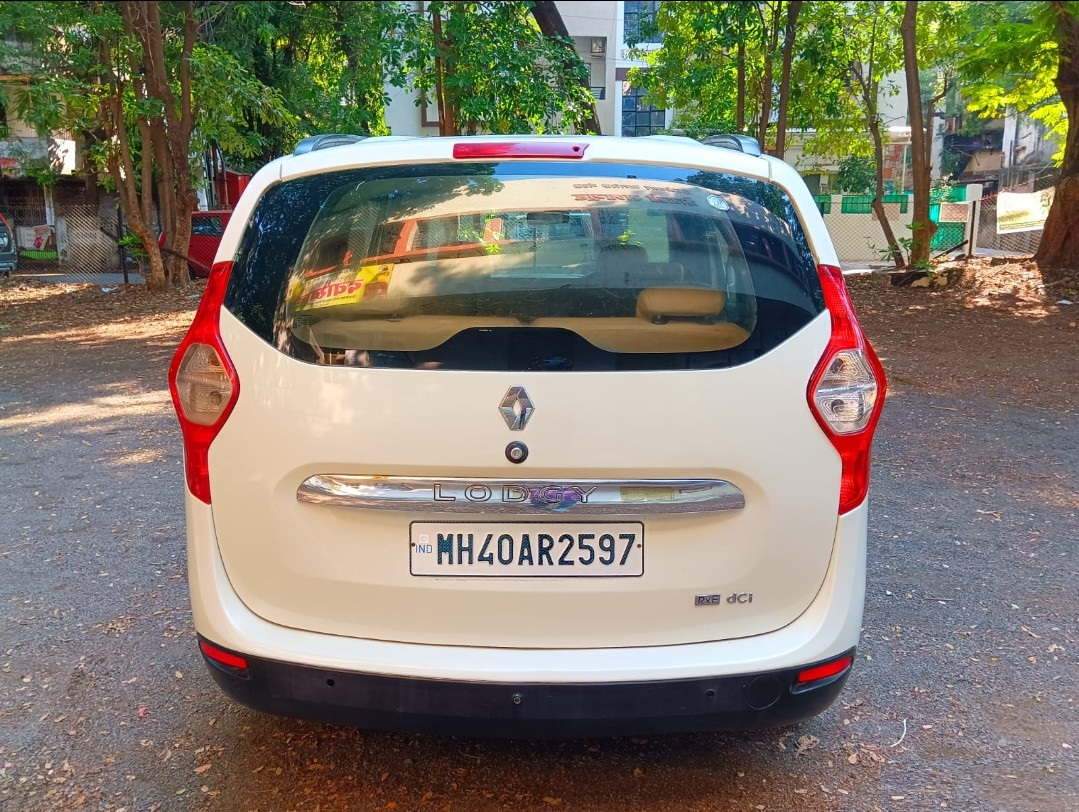

car


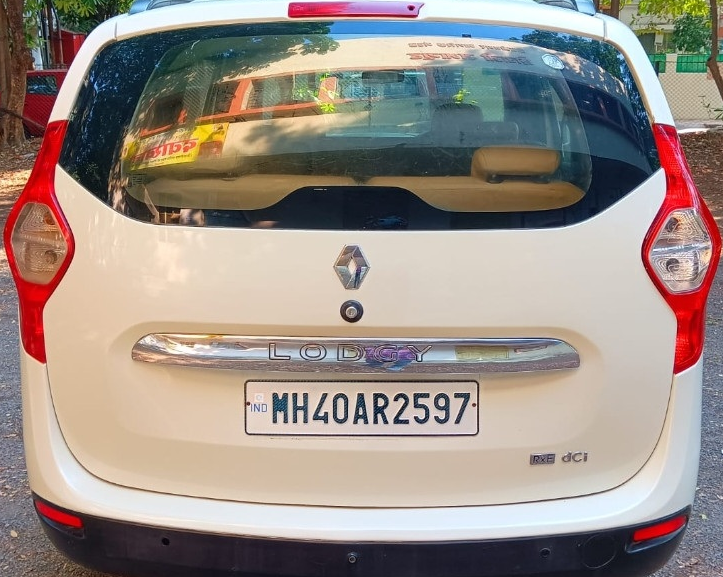

[INFO] Extract NumberPlate using Method 1...


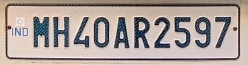

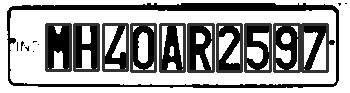

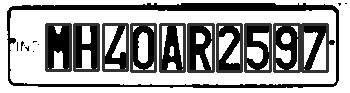

1/1 [==============================] - 0s 35ms/step
MHL0AR2597


In [ ]:
image_file = '/content/drive/MyDrive/Project/TestImages/rear_view1.jpg'
from_static_image(image_file)

### Show Output in CSV File

In [ ]:
import pandas as pd
csvfile = "/content/drive/My Drive/Project/demo.csv"
df = pd.read_csv(csvfile)
print(df)

   ID Type Plate Number
0   1  car   MHL0AR2597


### Plate Localization Using Coutours And Performing Perspective Transformation

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import imutils
import matplotlib.pyplot as plt

def extractNumberCountours(img_file):
    image_ = cv2.imread(img_file)
    plt.imshow(cv2.cvtColor(image_, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.show()

    image = imutils.resize(image_, width=500)

    # Determine scaling factors
    scale_x = image_.shape[1] / image.shape[1]
    scale_y = image_.shape[0] / image.shape[0]

    img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the original image
    fig, ax = plt.subplots(2, 2, figsize=(10,7))
    ax[0,0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[0,0].set_title('Original Image')

    # RGB to Gray scale conversion
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ax[0,1].imshow(gray, cmap='gray')
    ax[0,1].set_title('Grayscale Conversion')

    # Noise removal with iterative bilateral filter(removes noise while preserving edges)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)
    ax[1,0].imshow(gray, cmap='gray')
    ax[1,0].set_title('Bilateral Filter')

    # Find Edges of the grayscale image
    edged = cv2.Canny(gray, 170, 200)
    ax[1,1].imshow(edged, cmap='gray')
    ax[1,1].set_title('Canny Edges')

    fig.tight_layout()
    plt.show()

    # Find contours based on Edges
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
    cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30]
    NumberPlateCnt = None #we currently have no Number plate contour
    NewNumberPlate = []

    ROI = None
    count = 0
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:  # Select the contour with 4 corners
            NumberPlateCnt = approx #This is our approx Number Plate Contour
            x,y,w,h = cv2.boundingRect(c)
            ROI = img[y:y+h, x:x+w]
            if NumberPlateCnt is not None:
                # Drawing the selected contour on the original image
                cv2.drawContours(image, [NumberPlateCnt], -1, (0,255,0), 3)
                break

    if NumberPlateCnt is not None:
        # Drawing the selected contour on the original image
        cv2.drawContours(image, [NumberPlateCnt], -1, (0,255,0), 3)
        for point in NumberPlateCnt:
          NewNumberPlate.append((point * np.array([scale_x, scale_y])).tolist())
          # NewNumberPlate.append((point).tolist())
        # print(NumberPlateCnt)
        NewNumberPlate = [[int(x[0][0]),int(x[0][1])] for x in NewNumberPlate]

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Detected license plate")
    plt.show()
    return NewNumberPlate

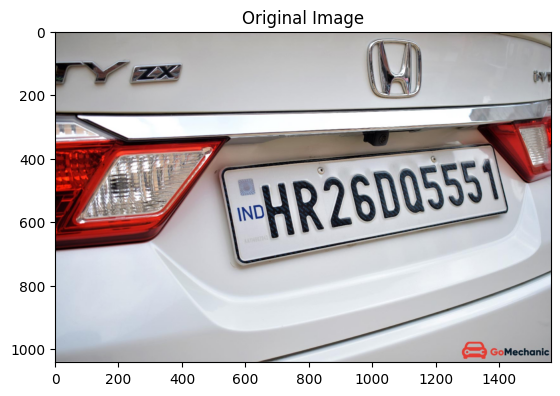

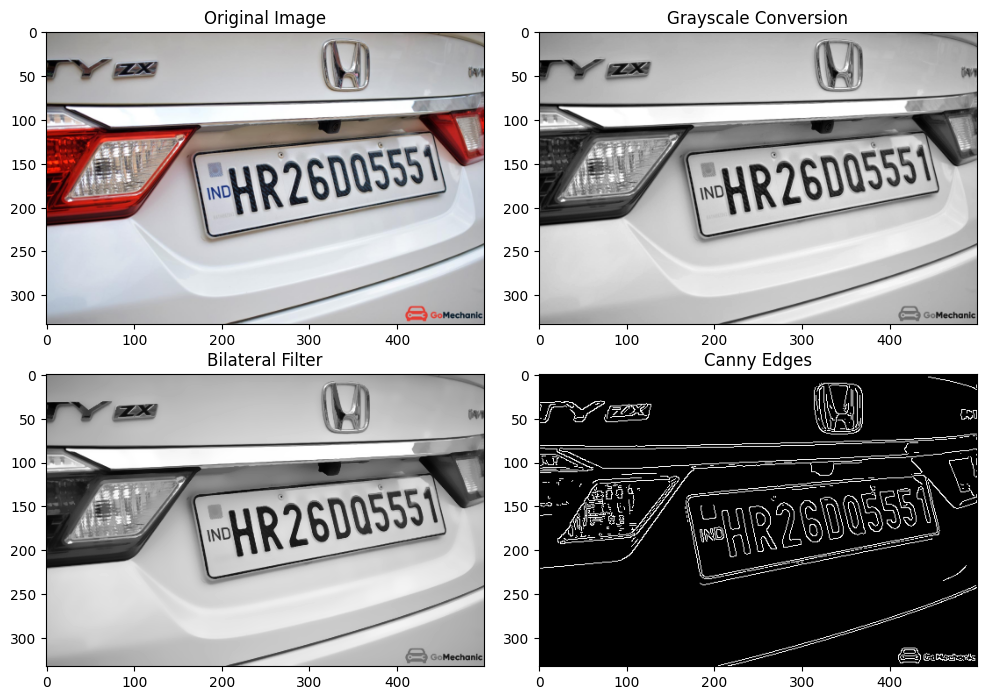

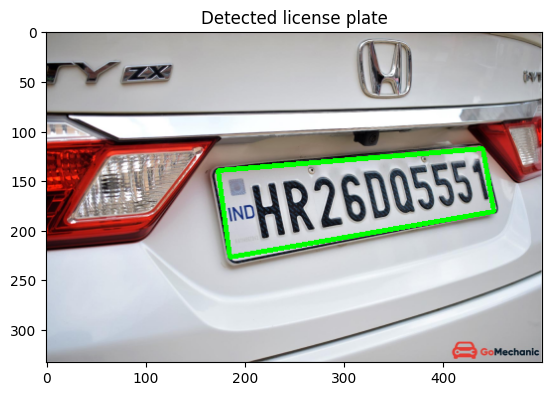

Change Perspective


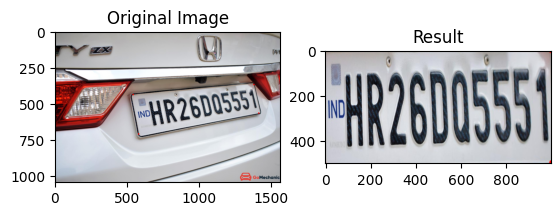

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import heapq

img = cv2.imread("/content/drive/MyDrive/Project/TestImages/type2.jpg")
NewNumberPlate = extractNumberCountours('/content/drive/MyDrive/Project/TestImages/type2.jpg')

NewNumberPlate = order_edges(NewNumberPlate)
cv2.circle(img, tuple(NewNumberPlate[0]), 5, (0, 0, 255), -1) # top left
cv2.circle(img, tuple(NewNumberPlate[1]), 5, (0, 0, 255), -1) # top right
cv2.circle(img, tuple(NewNumberPlate[2]), 5, (0, 0, 255), -1) # bottom left
cv2.circle(img, tuple(NewNumberPlate[3]), 5, (0, 0, 255), -1) # bottom right

pts1 = np.float32(NewNumberPlate)

pts2 = np.float32(
        [[0,0], # top left
         [1000,0], # top right
         [0,500], # bottom left
         [1000,500]] # bottom right
)

print("Change Perspective")
matrix = cv2.getPerspectiveTransform(pts1,pts2)
result = cv2.warpPerspective(img, matrix, (1000,500)) # set size image based on pts2 (w = 500 h = 600)

plt.subplot(1,2,1),
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1,2,2),
plt.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB))
plt.title('Result')
cv2.imwrite('/content/Numberplate.jpg',result)

plt.show()

### Output Using First Model

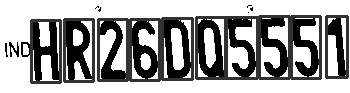

'HR2SD05551'

In [ ]:
show_results(cv2.imread("/content/Numberplate.jpg"))

### Output Using Second Model

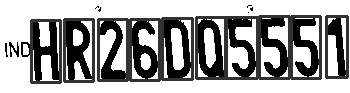

1/1 [==============================] - 0s 211ms/step


'HR26D0K551'

In [ ]:
show_results2(cv2.imread("/content/Numberplate.jpg"))

### Plate Localization Using HaarCascade XML

Number of detected license plates: 1


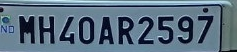

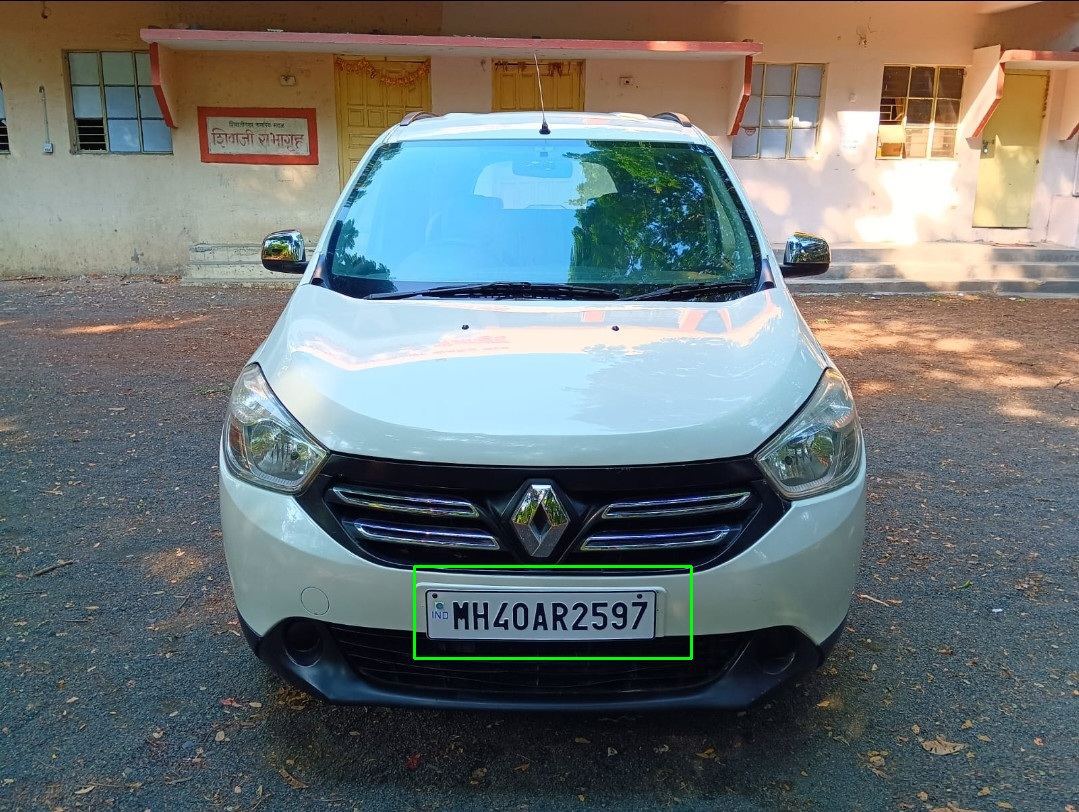

In [ ]:
# import required libraries
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Read input image
img = cv2.imread("/content/drive/MyDrive/Project/TestImages/front_view2.jpg")

# convert input image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# read haarcascade for number plate detection
cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Project/haarcascade_number_plate.xml')

# Detect license number plates
plates = cascade.detectMultiScale(gray, 1.2, 5)
print('Number of detected license plates:', len(plates))

# loop over all plates
for (x,y,w,h) in plates:

   # draw bounding rectangle around the license number plate
   cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 2)
   gray_plates = gray[y:y+h, x:x+w]
   color_plates = img[y+20:y+h-20, x+20:x+w-20]

   # save number plate detected
   cv2.imwrite('/content/Numberplate.jpg', color_plates)
   cv2_imshow(color_plates)
   cv2_imshow(img)

### Output

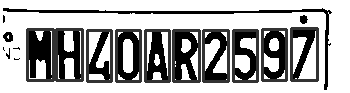

'MHI0AR2597'

In [ ]:
img = cv2.imread("/content/Numberplate.jpg")
show_results(img)

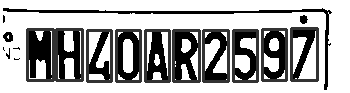

1/1 [==============================] - 0s 52ms/step


'MHL0AR2597'

In [ ]:
img = cv2.imread("/content/Numberplate.jpg")
show_results2(img)